In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import IPython.display as display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

import sklearn.model_selection as sk

import os, pathlib, math, datetime

In [3]:
# graphwiz path variable
os.environ["PATH"] += os.pathsep + "D:/Program Files (x86)/Graphwiz2.38/bin/"

# autotune constant
autotune = tf.data.experimental.AUTOTUNE

# seed
seed = 42069

In [4]:
# dataset path

path = "D:\\jupyter_notebook\\virtualenv_keras\\datasets\\"
dir_name = "aptos2019-blindness-detection"
data_dir = pathlib.Path(path + dir_name)

print("Data directory: ", data_dir)
print("Content: ", os.listdir(data_dir))

Data directory:  D:\jupyter_notebook\virtualenv_keras\datasets\aptos2019-blindness-detection
Content:  ['sample_submission.csv', 'test.csv', 'test_images', 'train.csv', 'train_images']


In [5]:
# set directory
train_dir = pathlib.Path(os.path.join(data_dir, "train_images"))
test_dir = pathlib.Path(os.path.join(data_dir, "test_images"))

csv_sample_submit = pathlib.Path(os.path.join(data_dir, "sample_submission.csv"))
csv_test = pathlib.Path(os.path.join(data_dir, "test.csv"))
csv_train = pathlib.Path(os.path.join(data_dir, "train.csv"))

In [6]:
data = pd.read_csv(csv_train)
filenames = list([
   os.path.abspath(train_dir) 
   + "\\" 
   + fname for fname in data["id_code"] 
   + ".png"])
labels = list(data["diagnosis"])

train_filenames, test_filenames, train_labels, test_labels = sk.train_test_split(
   filenames,
   labels,
   train_size = 0.8,
   random_state = seed
)

In [7]:
train_data = tf.data.Dataset.from_tensor_slices(
   (tf.constant(train_filenames),tf.constant(train_labels))
)

test_data = tf.data.Dataset.from_tensor_slices(
   (tf.constant(test_filenames),tf.constant(test_labels))
)

In [8]:
# perform image statistics
size_images = dict()

for dirpath, _, filenames in os.walk(train_dir):
   for path_image in filenames:
      image = os.path.abspath(os.path.join(dirpath, path_image))
      with Image.open(image) as img:
         width, heigth = img.size
         size_images[path_image] = {
            'width': width, 
            'heigth': heigth
         }

In [9]:
df_size_images = pd.DataFrame(size_images).T
data_statistics = df_size_images.describe()
data_statistics

,width,heigth
count,3662.000000,3662.000000
mean,2015.176679,1526.830147
std,884.301940,542.663120
min,474.000000,358.000000
25%,1050.000000,1050.000000
50%,2144.000000,1536.000000
75%,2588.000000,1958.000000
max,4288.000000,2848.000000


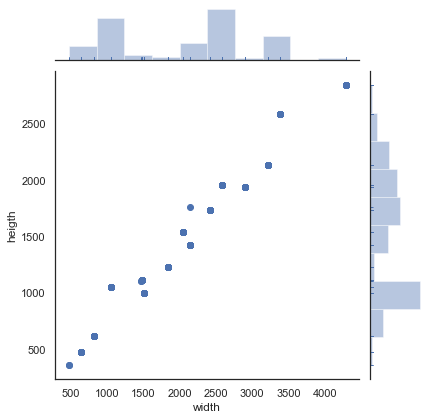

In [10]:
sns.set(style = "white", color_codes = True)
sns.jointplot(
   x = "width",
   y = "heigth",
   data = df_size_images,
   marginal_kws = dict(bins = 10, rug = True)
)

In [11]:
data.groupby("diagnosis").count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [12]:
class_names = range(5)

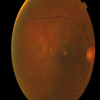

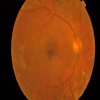

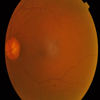

<Figure size 720x432 with 0 Axes>

In [13]:
sample = list(train_dir.glob("*"))

plt.figure(figsize = (10, 6))
for image_path in sample[:3]:
   display.display(Image.open(str(image_path)).resize((100, 100)))

In [14]:
batch_size = 10
img_width = 300
img_height = 300

def encode_label(label):
   return label == class_names

def decode_image(img):
   img = tf.image.decode_png(img, channels = 3)
   img = tf.image.convert_image_dtype(img, tf.float32)
   return tf.image.resize(img, [img_width, img_height])

def process_path(filename, label):
   label = encode_label(label)
   img = tf.io.read_file(filename)
   img = decode_image(img)
   return img, label

In [15]:
train_data = train_data.map(process_path, num_parallel_calls = autotune)
test_data = test_data.map(process_path, num_parallel_calls = autotune)

In [16]:
for image, label in train_data.take(1):
   print("Image shape: ", image.numpy().shape)
   print("Label", label.numpy())

Image shape:  (300, 300, 3)
Label [False False  True False False]


In [17]:
def prepare_for_training(dataset, cache = True, shuffle_buffer_size = 1000):
   if cache:
      if isinstance(cache, str):
         dataset = dataset.cache(cache)
      else:
         daaset = dataset.cache()
         
   dataset = dataset.shuffle(buffer_size = shuffle_buffer_size).repeat().batch(batch_size).prefetch(buffer_size = autotune)
   return dataset

In [18]:
prepared_train_data = prepare_for_training(train_data)
prepared_test_data = prepare_for_training(test_data)

In [19]:
model = Sequential([
   Conv2D(16, 3, padding = "same", activation = "relu", input_shape = (img_width, img_height, 3)),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(32, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(64, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(128, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Flatten(),
   Dense(512, activation='relu'),
   Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        1

In [21]:
history = model.fit(
   prepared_train_data,
   epochs = 20,
   steps_per_epoch = 100,
   validation_data = prepared_test_data,
   validation_steps = 100,
)

Train for 100 steps, validate for 100 steps
Epoch 1/20
100/100 [==============================] - 241s 2s/step - loss: 0.3802 - accuracy: 0.8588 - val_loss: 0.2993 - val_accuracy: 0.8824
Epoch 2/20
100/100 [==============================] - 184s 2s/step - loss: 0.2898 - accuracy: 0.8812 - val_loss: 0.2899 - val_accuracy: 0.8736
Epoch 3/20
 83/100 [=======================>......] - ETA: 12s - loss: 0.2729 - accuracy: 0.8912

KeyboardInterrupt: 